In [284]:
import logging
import sqlite3
import json
from datetime import datetime

# import numpy as np
import pandas as pd
import numpy as np

# trading_ig
from trading_ig.rest import IGService
from trading_ig.config import config

import yfinance as yf
from datetime import timedelta
from datetime import datetime

# plotting
import plotnine as pn
from plotnine import ggplot, aes, geom_col, theme, geom_point,scale_x_continuous ,scale_y_continuous

In [323]:
def format_date(d):
    return d.strftime("%Y-%m-%d")


# config
DAYS_AWAY = 10
STARTDATE = format_date(datetime.now() - timedelta(days=DAYS_AWAY))
ENDDATE = format_date(datetime.now() + timedelta(days=1))
RESOLUTION = "H"
GOLD_EPIC = "MT.D.GC.Month2.IP"
SANDP_EPIC = "IX.D.SPTRD.DAILY.IP"


In [324]:
def create_open_position_config(epic,size = None,direction = 'BUY'):

    market = ig_service.fetch_market_by_epic(epic)
    expiry = market.instrument['expiry']
    minsize= market.dealingRules['minDealSize']['value']
    if size is None:
        size = minsize
    else:
        if size<minsize:
            raise ValueError("Size of trade too small")
    res = {
        'currency_code':'GBP',
        'direction':direction,
        'epic':epic,
        'order_type':'MARKET',
        'expiry':expiry,
        'force_open':'false',
        'guaranteed_stop':'false',
        'size':size,
        'level':None,
        'limit_distance':None,
        'limit_level':None,
        'quote_id':None,
        'stop_level':None,
        'stop_distance':None,
        'trailing_stop':None,
        'trailing_stop_increment':None
        }
    return res

In [325]:
ig_service = IGService(config.username, config.password, config.api_key)
ig = ig_service.create_session()

In [326]:
market = ig_service.fetch_market_by_epic(GOLD_EPIC)
print(f"Keys: {list(market.keys())}")
print(json.dumps(market.instrument,indent=4))

Keys: ['instrument', 'dealingRules', 'snapshot']
{
    "epic": "MT.D.GC.Month2.IP",
    "expiry": "AUG-22",
    "name": "Gold",
    "forceOpenAllowed": true,
    "stopsLimitsAllowed": true,
    "lotSize": 1.0,
    "unit": "AMOUNT",
    "type": "COMMODITIES",
    "controlledRiskAllowed": true,
    "streamingPricesAvailable": true,
    "marketId": "GC",
    "currencies": [
        {
            "code": "USD",
            "symbol": "$",
            "baseExchangeRate": 1.265411,
            "exchangeRate": 0.66,
            "isDefault": false
        },
        {
            "code": "AUD",
            "symbol": "A$",
            "baseExchangeRate": 1.758255,
            "exchangeRate": 0.45,
            "isDefault": false
        },
        {
            "code": "EUR",
            "symbol": "E",
            "baseExchangeRate": 1.173425,
            "exchangeRate": 0.9,
            "isDefault": false
        },
        {
            "code": "GBP",
            "symbol": "\u00a3",
           

In [327]:
print(json.dumps(market.dealingRules,indent=4))

{
    "minStepDistance": {
        "unit": "POINTS",
        "value": 1.0
    },
    "minDealSize": {
        "unit": "POINTS",
        "value": 0.5
    },
    "minControlledRiskStopDistance": {
        "unit": "POINTS",
        "value": 2.0
    },
    "minNormalStopOrLimitDistance": {
        "unit": "POINTS",
        "value": 1.0
    },
    "maxStopOrLimitDistance": {
        "unit": "PERCENTAGE",
        "value": 75.0
    },
    "controlledRiskSpacing": {
        "unit": "POINTS",
        "value": 3.0
    },
    "marketOrderPreference": "AVAILABLE_DEFAULT_OFF",
    "trailingStopsPreference": "AVAILABLE"
}


In [328]:
print(json.dumps(market.snapshot,indent=4))

{
    "marketStatus": "TRADEABLE",
    "netChange": 1,
    "percentageChange": 0.05,
    "updateTime": "17:13:02",
    "delayTime": 0,
    "bid": 1858.4,
    "offer": 1859.0,
    "high": 1868.1,
    "low": 1850.2,
    "binaryOdds": null,
    "decimalPlacesFactor": 1,
    "scalingFactor": 1,
    "controlledRiskExtraSpread": 0.3
}


In [330]:
# see from pandas.tseries.frequencies import to_offset
# resolution = '1Min'
result = ig_service.fetch_historical_prices_by_epic(
    epic=GOLD_EPIC, start_date=STARTDATE, end_date=ENDDATE, resolution=RESOLUTION
)
print(f"Keys: {list(result.keys())}")
print(result["instrumentType"])
prices_raw = result["prices"]
print(prices_raw.shape)
prices_raw.head(3)


Keys: ['prices', 'instrumentType', 'metadata']
COMMODITIES
(157, 13)


bid                             ask                  \
                       Open    High     Low   Close    Open    High     Low   
DateTime                                                                      
2022-05-20 00:00:00  1846.6  1849.3  1846.2  1846.8  1847.2  1849.9  1846.8   
2022-05-20 01:00:00  1846.9  1848.1  1844.8  1846.1  1847.5  1848.7  1845.4   
2022-05-20 02:00:00  1846.2  1846.9  1842.3  1842.8  1846.8  1847.5  1842.9   

                            last                        
                      Close Open High Low Close Volume  
DateTime                                                
2022-05-20 00:00:00  1847.4  NaN  NaN NaN   NaN     52  
2022-05-20 01:00:00  1846.7  NaN  NaN NaN   NaN     87  
2022-05-20 02:00:00  1843.4  NaN  NaN NaN   NaN    159

In [349]:
def standardise_column_names(df):
    df_new = df.copy()
    df_new.columns = ["_".join(i).lower() for i in df_new.columns]
    return df_new



prices = standardise_column_names( prices_raw)
prices  = prices.reset_index()
prices.head(3)

,DateTime,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close,last_open,last_high,last_low,last_close,last_volume
0,2022-05-20 00:00:00,1846.6,1849.3,1846.2,1846.8,1847.2,1849.9,1846.8,1847.4,NaN,NaN,NaN,NaN,52
1,2022-05-20 01:00:00,1846.9,1848.1,1844.8,1846.1,1847.5,1848.7,1845.4,1846.7,NaN,NaN,NaN,NaN,87
2,2022-05-20 02:00:00,1846.2,1846.9,1842.3,1842.8,1846.8,1847.5,1842.9,1843.4,NaN,NaN,NaN,NaN,159


In [332]:
def to_hours(td):
    "Gives the number of hours diffreence between two timedeltas"
    return td.days*24+ td.seconds//3600
to_hours(prices.DateTime[136] - prices.DateTime[0])

189

In [352]:
prices = prices.assign(
    days_since=lambda df: list(map(lambda x: to_hours(x), (df["DateTime"] - df["DateTime"][0])))
)
prices

,DateTime,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close,last_open,last_high,last_low,last_close,last_volume,train_test,days_since
0,2022-05-20 00:00:00,1846.6,1849.3,1846.2,1846.8,1847.2,1849.9,1846.8,1847.4,NaN,NaN,NaN,NaN,52,train,0
1,2022-05-20 01:00:00,1846.9,1848.1,1844.8,1846.1,1847.5,1848.7,1845.4,1846.7,NaN,NaN,NaN,NaN,87,train,1
2,2022-05-20 02:00:00,1846.2,1846.9,1842.3,1842.8,1846.8,1847.5,1842.9,1843.4,NaN,NaN,NaN,NaN,159,train,2
3,2022-05-20 03:00:00,1842.9,1843.8,1841.0,1843.3,1843.5,1844.4,1841.6,1843.9,NaN,NaN,NaN,NaN,120,train,3
4,2022-05-20 04:00:00,1843.4,1846.3,1843.4,1846.3,1844.0,1846.9,1844.0,1846.9,NaN,NaN,NaN,NaN,95,train,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2022-05-30 14:00:00,1858.4,1864.2,1858.1,1862.2,1859.0,1864.8,1858.7,1862.8,NaN,NaN,NaN,NaN,3949,train,254
153,2022-05-30 15:00:00,1862.3,1862.3,1857.5,1861.8,1862.9,1862.9,1858.1,1862.4,NaN,NaN,NaN,NaN,3764,train,255
154,2022-05-30 16:00:00,1861.9,1861.9,1858.1,1858.9,1862.5,1862.5,1858.7,1859.5,NaN,NaN,NaN,NaN,1728,train,256
155,2022-05-30 17:00:00,1858.8,1859.9,1858.4,1859.2,1859.4,1860.5,1859.0,1859.8,NaN,NaN,NaN,NaN,1138,train,257


In [353]:
test_size = 0
prices = prices.assign(
    train_test=["train"] * (len(prices) - test_size) + ["test"] * test_size
)
prices.train_test.value_counts()

train    157
Name: train_test, dtype: int64

In [354]:
from sklearn.linear_model import LinearRegression
train = prices.query("train_test=='train'")
test = prices.query("train_test=='test'")
X_train = train.days_since.to_numpy().reshape(-1,1)
X_test = test.days_since.to_numpy().reshape(-1,1)
y_train = train.bid_open
y_test = test.bid_open


In [355]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

linearModpipeline = Pipeline(
    [("poly", PolynomialFeatures(degree=3))]
        )

linearModpipeline.fit(X_train)
X_train_preprocessed = linearModpipeline.transform(X_train)


In [356]:
linearMod = LinearRegression(fit_intercept=True)
linearMod.fit(X_train_preprocessed,y_train)

LinearRegression()

In [367]:
(X_train[-1]+1).reshape(-1,1)


array([[259]])

In [368]:
y_predictions = linearMod.predict(linearModpipeline.transform((X_train[-1]+1).reshape(-1,1)))
y_predictions

array([1862.14242508])

In [339]:
from sklearn.metrics import mean_squared_error


In [348]:
# open_positions = ig_service.fetch_open_positions()
# open_positions = (
#     open_positions.assign(
#         direction_signed=lambda df: np.where(df.direction == "SELL", -1, 1),
#         size_signed=lambda df: df['size'] * df.direction_signed
#     )
# )
# open_positions_totals = open_positions.groupby('epic',as_index=False)['size_signed'].sum()
# open_positions_totals

def get_open_position_totals():
    open_positions = ig_service.fetch_open_positions()
    
    open_positions = (
    open_positions.assign(
        direction_signed=lambda df: np.where(df.direction == "SELL", -1, 1),
        size_signed=lambda df: df['size'] * df.direction_signed
    )
)
    open_positions_totals = open_positions.groupby('epic',as_index=False)['size_signed'].sum()
    return open_positions_totals   
get_open_position_totals()


,epic,size_signed
0,MT.D.GC.Month2.IP,0.07


In [345]:
downscaling= 50
total_size = open_positions_totals[open_positions_totals.epic == GOLD_EPIC]['size_signed']
total_size = float(total_size)
size_wanted =  ( y_predictions[0]-y_train.iloc[-1] )/downscaling
print(size_wanted)
change_needed = (size_wanted-total_size).round(2)
print(f"Size wanted: {size_wanted.round(2)}")
print(f"Toal size: {total_size}")
print(f"change needed: {change_needed.round(2)}")


    

0.0668012063453898
Size wanted: 0.07
Toal size: -0.54
change needed: 0.61


In [346]:
if change_needed> 0 :
    print("We're buying!")
    print(position_info(GOLD_EPIC,direction = 'BUY'))
    ig_service.create_open_position(**position_info(GOLD_EPIC,size= abs(change_needed),direction = 'BUY'))
if change_needed < 0:
    print("We're selling!")
    print(position_info(GOLD_EPIC,direction = 'SELL'))
    res = ig_service.create_open_position(**position_info(GOLD_EPIC,direction = 'SELL',size = abs(change_needed)))
    print(res)
if change_needed==0:
    print("No trade needed")


We're buying!
{'currency_code': 'GBP', 'direction': 'BUY', 'epic': 'MT.D.GC.Month2.IP', 'order_type': 'MARKET', 'expiry': 'AUG-22', 'force_open': 'false', 'guaranteed_stop': 'false', 'size': 0.5, 'level': None, 'limit_distance': None, 'limit_level': None, 'quote_id': None, 'stop_level': None, 'stop_distance': None, 'trailing_stop': None, 'trailing_stop_increment': None}


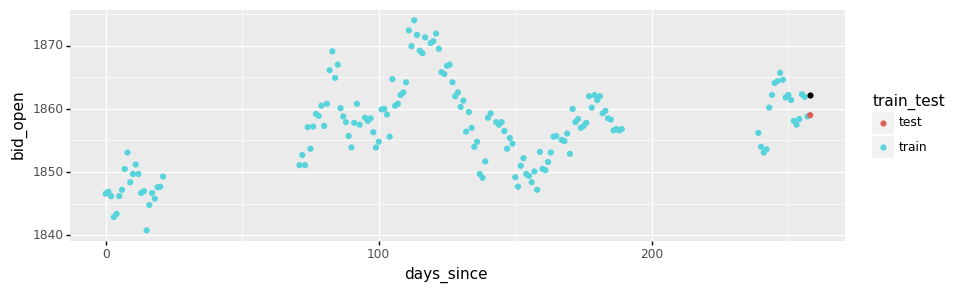

<ggplot: (316604624)>

In [342]:
(
    ggplot(prices)+
    geom_point(aes('days_since','bid_open',color = 'train_test'))+
    theme(figure_size = [10,3])+
    pn.geom_point(data = test,mapping = aes('days_since',y_predictions))
)

In [61]:
ig_service.create_open_position(**position_info(sandp_epic,direction='SELL'))

{'date': '2022-05-30T13:07:25.841',
 'status': 'CLOSED',
 'reason': 'SUCCESS',
 'dealStatus': 'ACCEPTED',
 'epic': 'IX.D.SPTRD.DAILY.IP',
 'expiry': 'DFB',
 'dealReference': 'DBPVYBR4N34TYNK',
 'dealId': 'DIAAAAJJDY8J2AG',
 'affectedDeals': [{'dealId': 'DIAAAAJJDY8J2AG', 'status': 'FULLY_CLOSED'}],
 'level': 4183.26,
 'size': 0.5,
 'direction': 'SELL',
 'stopLevel': None,
 'limitLevel': None,
 'stopDistance': None,
 'limitDistance': None,
 'guaranteedStop': False,
 'trailingStop': False,
 'profit': -0.55,
 'profitCurrency': 'GBP'}

In [266]:
open_positions = ig_service.fetch_open_positions()
open_positions

,contractSize,createdDate,createdDateUTC,dealId,dealReference,size,direction,limitLevel,level,currency,...,percentageChange,netChange,bid,offer,updateTime,updateTimeUTC,delayTime,streamingPricesAvailable,marketStatus,scalingFactor
0,1.0,2022/05/30 17:03:09:000,2022-05-30T16:03:09,DIAAAAJJFPFRVA6,QJX4DYA7TTYTYNK,0.54,SELL,None,1858.7,GBP,...,0.06,1.2,1858.6,1859.2,17:03:14,16:03:14,0,True,TRADEABLE,1


In [267]:
open_positions.columns

Index(['contractSize', 'createdDate', 'createdDateUTC', 'dealId',
       'dealReference', 'size', 'direction', 'limitLevel', 'level', 'currency',
       'controlledRisk', 'stopLevel', 'trailingStep', 'trailingStopDistance',
       'limitedRiskPremium', 'instrumentName', 'expiry', 'epic',
       'instrumentType', 'lotSize', 'high', 'low', 'percentageChange',
       'netChange', 'bid', 'offer', 'updateTime', 'updateTimeUTC', 'delayTime',
       'streamingPricesAvailable', 'marketStatus', 'scalingFactor'],
      dtype='object')

In [269]:
open_positions = (
    open_positions.assign(
        direction_signed=lambda df: np.where(df.direction == "SELL", -1, 1),
        size_signed=lambda df: df['size'] * df.direction_signed
    )
)
open_positions_totals = open_positions.groupby('epic',as_index=False)['size_signed'].sum()
open_positions_totals


,epic,size_signed
0,MT.D.GC.Month2.IP,-0.54


In [6]:
result = ig_service.fetch_historical_prices_by_epic(
    epic='CS.D.USCGC.TODAY.IP',
    start_date="2022-02-01",
    end_date="2022-02-03",resolution="4H"
    )
result['prices']

bid                                 ask           \
                        Open     High      Low    Close     Open     High   
DateTime                                                                    
2022-02-01 00:00:00  1797.58  1799.21  1795.52  1796.41  1798.08  1799.71   
2022-02-01 04:00:00  1796.42  1804.23  1796.12  1803.97  1796.92  1804.70   
2022-02-01 08:00:00  1803.96  1808.21  1801.69  1806.13  1804.26  1808.58   
2022-02-01 12:00:00  1806.15  1808.64  1797.59  1804.32  1806.45  1809.14   
2022-02-01 16:00:00  1804.31  1807.81  1799.17  1799.31  1804.61  1808.20   
2022-02-01 20:00:00  1799.26  1802.29  1798.33  1800.56  1799.56  1802.68   
2022-02-02 00:00:00  1800.58  1801.46  1797.14  1797.45  1801.08  1801.96   
2022-02-02 04:00:00  1797.48  1798.90  1794.25  1796.66  1797.98  1799.40   
2022-02-02 08:00:00  1796.65  1803.48  1796.31  1802.65  1796.95  1803.97   
2022-02-02 12:00:00  1802.66  1810.53  1800.31  1808.38  1803.16  1811.03   
2022-02-02 16:00:00  1808.36  1810.63  1807.15  1807.29  1808.86  1811.09   
2022-02-02 20:00:00  1807.28  1808.14  1804.95  1807.64  1807.78  1808.64   
2022-02-03 00:00:00  1807.74  1808.89  1805.78  1806.86  1808.04  1809.30   

                                      last                        
                         Low    Close Open High Low Close Volume  
DateTime                                                          
2022-02-01 00:00:00  1795.96  1796.91  NaN  NaN NaN   NaN  16731  
2022-02-01 04:00:00  1796.62  1804.27  NaN  NaN NaN   NaN  21791  
2022-02-01 08:00:00  1802.10  1806.43  NaN  NaN NaN   NaN  28129  
2022-02-01 12:00:00  1798.09  1804.62  NaN  NaN NaN   NaN  54681  
2022-02-01 16:00:00  1799.61  1799.61  NaN  NaN NaN   NaN  32270  
2022-02-01 20:00:00  1798.83  1801.06  NaN  NaN NaN   NaN  14087  
2022-02-02 00:00:00  1797.60  1797.95  NaN  NaN NaN   NaN  13295  
2022-02-02 04:00:00  1794.69  1796.96  NaN  NaN NaN   NaN  17624  
2022-02-02 08:00:00  1796.61  1803.15  NaN  NaN NaN   NaN  28738  
2022-02-02 12:00:00  1800.76  1808.88  NaN  NaN NaN   NaN  50055  
2022-02-02 16:00:00  1807.63  1807.79  NaN  NaN NaN   NaN  28855  
2022-02-02 20:00:00  1805.34  1808.14  NaN  NaN NaN   NaN  12681  
2022-02-03 00:00:00  1806.28  1807.36  NaN  NaN NaN   NaN  13645

In [68]:
ig

{'accountType': 'SPREADBET',
 'accountInfo': {'balance': 10643.19,
  'deposit': 92.87,
  'profitLoss': -56.07,
  'available': 10494.25},
 'currencyIsoCode': 'GBP',
 'currencySymbol': '£',
 'currentAccountId': 'Z4JO3H',
 'lightstreamerEndpoint': 'https://demo-apd.marketdatasystems.com',
 'accounts': [{'accountId': 'Z4JO3G',
   'accountName': 'CFD',
   'preferred': False,
   'accountType': 'CFD'},
  {'accountId': 'Z4JO3H',
   'accountName': 'Ezra Spread bet',
   'preferred': True,
   'accountType': 'SPREADBET'}],
 'clientId': '103142528',
 'timezoneOffset': 1,
 'hasActiveDemoAccounts': True,
 'hasActiveLiveAccounts': True,
 'trailingStopsEnabled': False,
 'reroutingEnvironment': None,
 'dealingEnabled': True}

In [4]:
msft = yf.Ticker("MSFT")

In [48]:
# get stock info
print(msft.info.keys())
msft.info['sector']

NameError: name 'msft' is not defined

In [15]:
from datetime import datetime,timedelta
today =datetime.now()#.strftime("%Y-%m-%d")
three_months_ago = today+timedelta(days=-90)

def format_date(date):
    return date.strftime("%Y-%m-%d")

In [16]:
history_raw = msft.history(
    period="1d",
    end = format_date(today),
    start = format_date(three_months_ago)
)
history_raw.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-18,303.442565,309.160722,301.117356,302.025482,42333200,0.0,0
2022-01-19,305.657985,313.262256,302.075397,302.704071,45933900,0.0,0
2022-01-20,308.432248,311.006911,300.518619,300.977661,35380700,0.0,0
2022-01-21,302.065420,303.482473,295.000012,295.419159,57984400,0.0,0
2022-01-24,291.597075,296.496917,275.480375,295.758453,85731500,0.0,0


In [ ]:
(
    ggplot(history_raw)+
    geom_point(aes(x,y))+
    theme()
)   

In [28]:
hist = hist_raw.reset_index().reset_index()

In [ ]:
## Fit a simple linear regression with a quadratic term to the last 3 months, and buy/ sell accordingly

In [58]:
# import statsmodels as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [66]:

X_poly[0:3]

array([[1., 0.],
       [1., 1.],
       [1., 2.]])

In [51]:
import plotnine as pn
from plotnine import ggplot, geom_line, aes

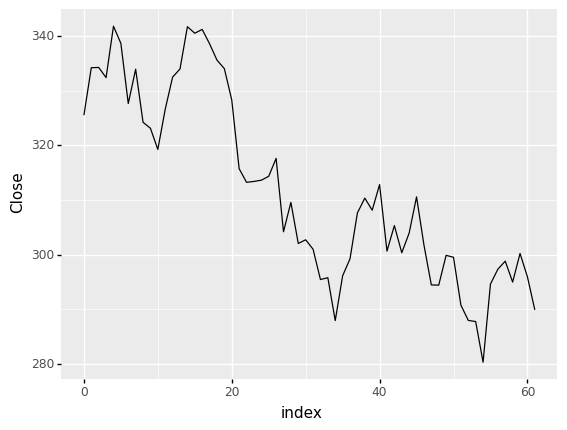

<ggplot: (302096649)>

In [23]:
(
    ggplot(hist.reset_index().reset_index())+
    geom_line(pn.aes('index','Close'))
    )


In [116]:
# np.array(hist['index']).reshape(-1,1)

In [117]:
linreg = LinearRegression()
linreg.fit(np.array(hist['index']).reshape(-1,1),  hist.Close)

LinearRegression()

In [118]:
polyreg =  LinearRegression()
poly =  PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(np.array(hist['index']).reshape(-1,1))
polyreg.fit(X_poly,hist.Close)

LinearRegression()

In [114]:
# inputs = np.linspace(0,60,100)
# poly = PolynomialFeatures(degree = 2)
# inputs = poly.fit_transform(inputs.reshape(-1,1))

# poly = PolynomialFeatures(degree = 3)
# inputs = poly.fit_transform(inputs.reshape(-1,1))



In [140]:
X_poly[:,1]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61.])

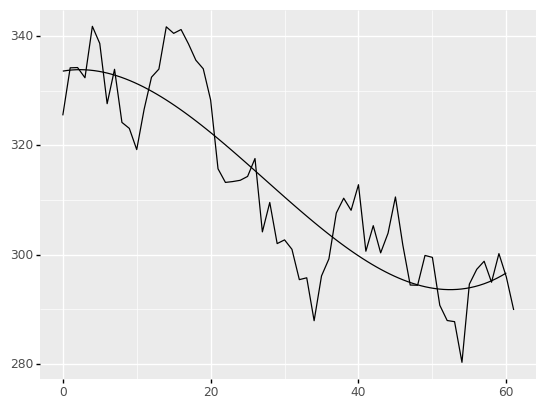

<ggplot: (306785818)>

In [145]:
def plot_model(model = linreg):
    inputs = np.linspace(0,60,100)
    inputs = poly.fit_transform(inputs.reshape(-1,1))

    preds= polyreg.predict(inputs)

    gg = (
        ggplot()+
        geom_line(aes(inputs[:,1],preds))+ # plot the model
        geom_line(aes(hist['index'],hist['Close']))
    )
    return gg

plot_model(polyreg)




In [42]:
linreg.predict(np.array([[1]]))

array([336.047157])

## misc

In [ ]:
## open a possition
resp = ig_service.create_open_position(
        currency_code='GBP',
        direction='BUY',
        epic=gold_epic,
        order_type='MARKET',
        expiry="AUG-22",
        force_open='false',
        guaranteed_stop='false',
        size=0.5,
        level=None,
        limit_distance=None,
        limit_level=None,
        quote_id=None,
        stop_level=None,
        stop_distance=None,
        trailing_stop=None,
        trailing_stop_increment=None
        )
resp